# Telecom Churn Prediction - Assignment Notebook

**Author:** Michael Thomas & Supriyo Roy

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# #INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
# #(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv", index_col=None)
unseen = pd.read_csv("test.csv", index_col=None)
sample = pd.read_csv("sample.csv", index_col=None)
data_dict = pd.read_csv("data_dictionary.csv", index_col=None)


print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Create X, y and then Train test split

Lets create X and y datasets and drop any column with only 1 unique value

In [4]:
data['circle_id'].unique()

array([109])

In [5]:
X = data.drop(['circle_id'], axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 170), (69999,))

In [6]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
69994    0
69995    0
69996    0
69997    0
69998    0
Name: churn_probability, Length: 69999, dtype: int64


In [7]:
print(X.columns)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=170)


In [8]:
X.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0   0             0.0             0.0             0.0            6/30/2014   
1   1             0.0             0.0             0.0            6/30/2014   
2   2             0.0             0.0             0.0            6/30/2014   
3   3             0.0             0.0             0.0            6/30/2014   
4   4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  ...  \
0            7/31/2014            8/31/2014   31.277   87.009    7.527  ...   
1            7/31/2014            8/31/2014    0.000  122.787   42.953  ...   
2            7/31/2014            8/31/2014   60.806  103.176    0.000  ...   
3            7/31/2014            8/31/2014  156.362  205.260  111.095  ...   
4            7/31/2014            8/31/2014  240.708  128.191  101.565  ...   

   sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0            0            0            0        NaN        NaN        NaN   
1            0            0            0        NaN        1.0        NaN   
2            0            0            0        NaN        NaN        NaN   
3            0            0            0        NaN        NaN        NaN   
4            0            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0  1958         0.0         0.0         0.0  
1   710         0.0         0.0         0.0  
2   882         0.0         0.0         0.0  
3   982         0.0         0.0         0.0  
4   647         0.0         0.0         0.0  

[5 rows x 170 columns]

Removing the date columns


In [9]:
# Dropping date columns, which don't appear to contribute to the results and are not numerical variables
columns_to_drop = [
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# Drop the specified columns from `data`
X = data.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 162), (69999,))

In [10]:
# Dropping columns that only have a single value, and does not contribute to the results
threshold = 1

# Find columns with unique value counts below the threshold
few_unique_cols = {col: X[col].nunique() for col in X.columns if X[col].nunique() <= threshold}

# Display the columns and their unique counts
print(few_unique_cols)



{'circle_id': 1, 'loc_og_t2o_mou': 1, 'std_og_t2o_mou': 1, 'loc_ic_t2o_mou': 1, 'std_og_t2c_mou_6': 1, 'std_og_t2c_mou_7': 1, 'std_og_t2c_mou_8': 1, 'std_ic_t2o_mou_6': 1, 'std_ic_t2o_mou_7': 1, 'std_ic_t2o_mou_8': 1}


In [11]:
# Filter out columns with only one unique value
single_value_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these columns from the DataFrame
X = X.drop(columns=single_value_columns)

# Display the shape of the updated DataFrame to confirm columns were dropped
X.shape


(69999, 152)

<Axes: >

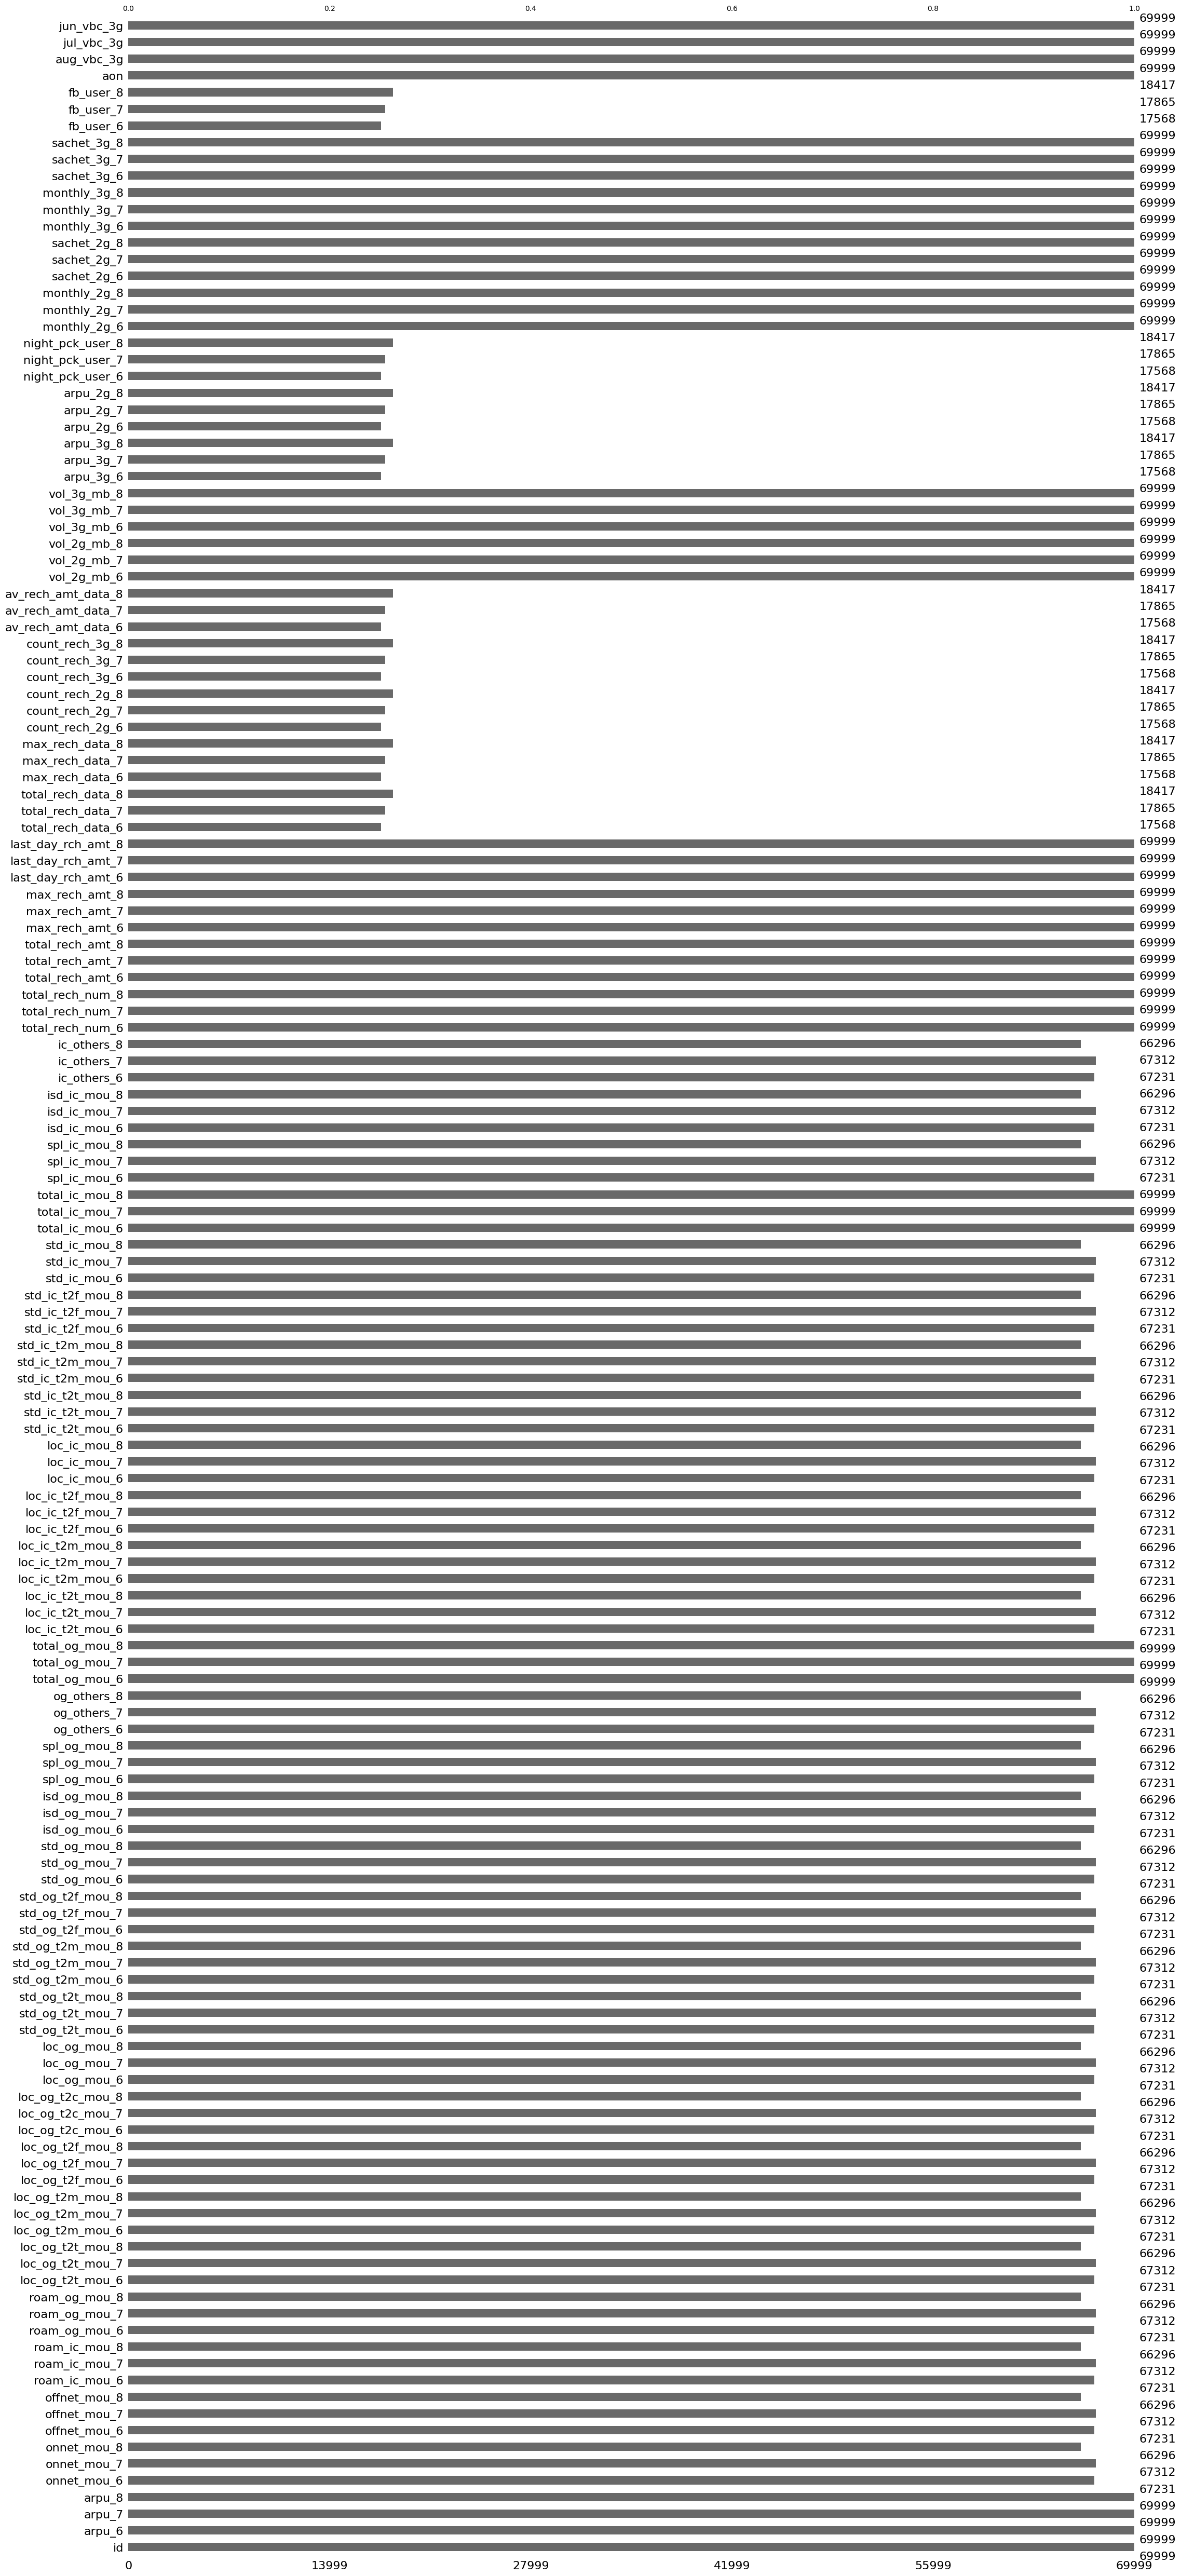

In [12]:
msno.bar(X)

In [13]:
missing_data_percent = 100*X.isnull().sum()/len(X)
missing_data_percent

id              0.000000
arpu_6          0.000000
arpu_7          0.000000
arpu_8          0.000000
onnet_mou_6     3.954342
                 ...    
fb_user_8      73.689624
aon             0.000000
aug_vbc_3g      0.000000
jul_vbc_3g      0.000000
jun_vbc_3g      0.000000
Length: 152, dtype: float64

In [14]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [15]:
X_filtered = X[new_vars]
X_filtered.shape

(69999, 125)

In [16]:
print(X_filtered.shape)
print(y.shape)


(69999, 125)
(69999,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((55999, 125), (14000, 125), (55999,), (14000,))

In [18]:
X_train.head()

id    arpu_6   arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
15793  15793   437.986    0.000     0.000        38.78         0.00   
13796  13796   249.659  193.990   173.788        68.76       142.93   
47608  47608   348.963  192.432     0.000        78.29        36.79   
9322    9322  1142.776  909.468  1387.055       783.59       368.64   
13636  13636   256.714  604.018   528.486        20.04        71.84   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
15793          NaN        823.86          0.00           NaN  ...   
13796        67.98         74.39         97.01          6.04  ...   
47608          NaN         91.18         43.24           NaN  ...   
9322        307.69        609.76        671.91       1683.51  ...   
13636       141.76        214.98        910.28        550.83  ...   

       monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
15793             0             0             0            0            0   
13796             0             0             0            0            0   
47608             0             0             0            0            0   
9322              1             0             0            0            0   
13636             0             0             0            0            0   

       sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
15793            0   185         0.0         0.0         0.0  
13796            0  1394         0.0         0.0         0.0  
47608            0  1105         0.0         0.0         0.0  
9322             0   190         0.0         0.0         0.0  
13636            0   548         0.0         0.0         0.0  

[5 rows x 125 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

## 3.1 Handling Missing data - Training Set

In [19]:
print(X_train.shape)
print(y.shape)


(55999, 125)
(69999,)


In [20]:
# Display the data types of each column
print(X_train.dtypes)


id               int64
arpu_6         float64
arpu_7         float64
arpu_8         float64
onnet_mou_6    float64
                ...   
sachet_3g_8      int64
aon              int64
aug_vbc_3g     float64
jul_vbc_3g     float64
jun_vbc_3g     float64
Length: 125, dtype: object


In [21]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_train.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [22]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_train_filtered = X_train.apply(pd.to_numeric, errors='coerce')

In [23]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 125)
(69999,)


<Axes: >

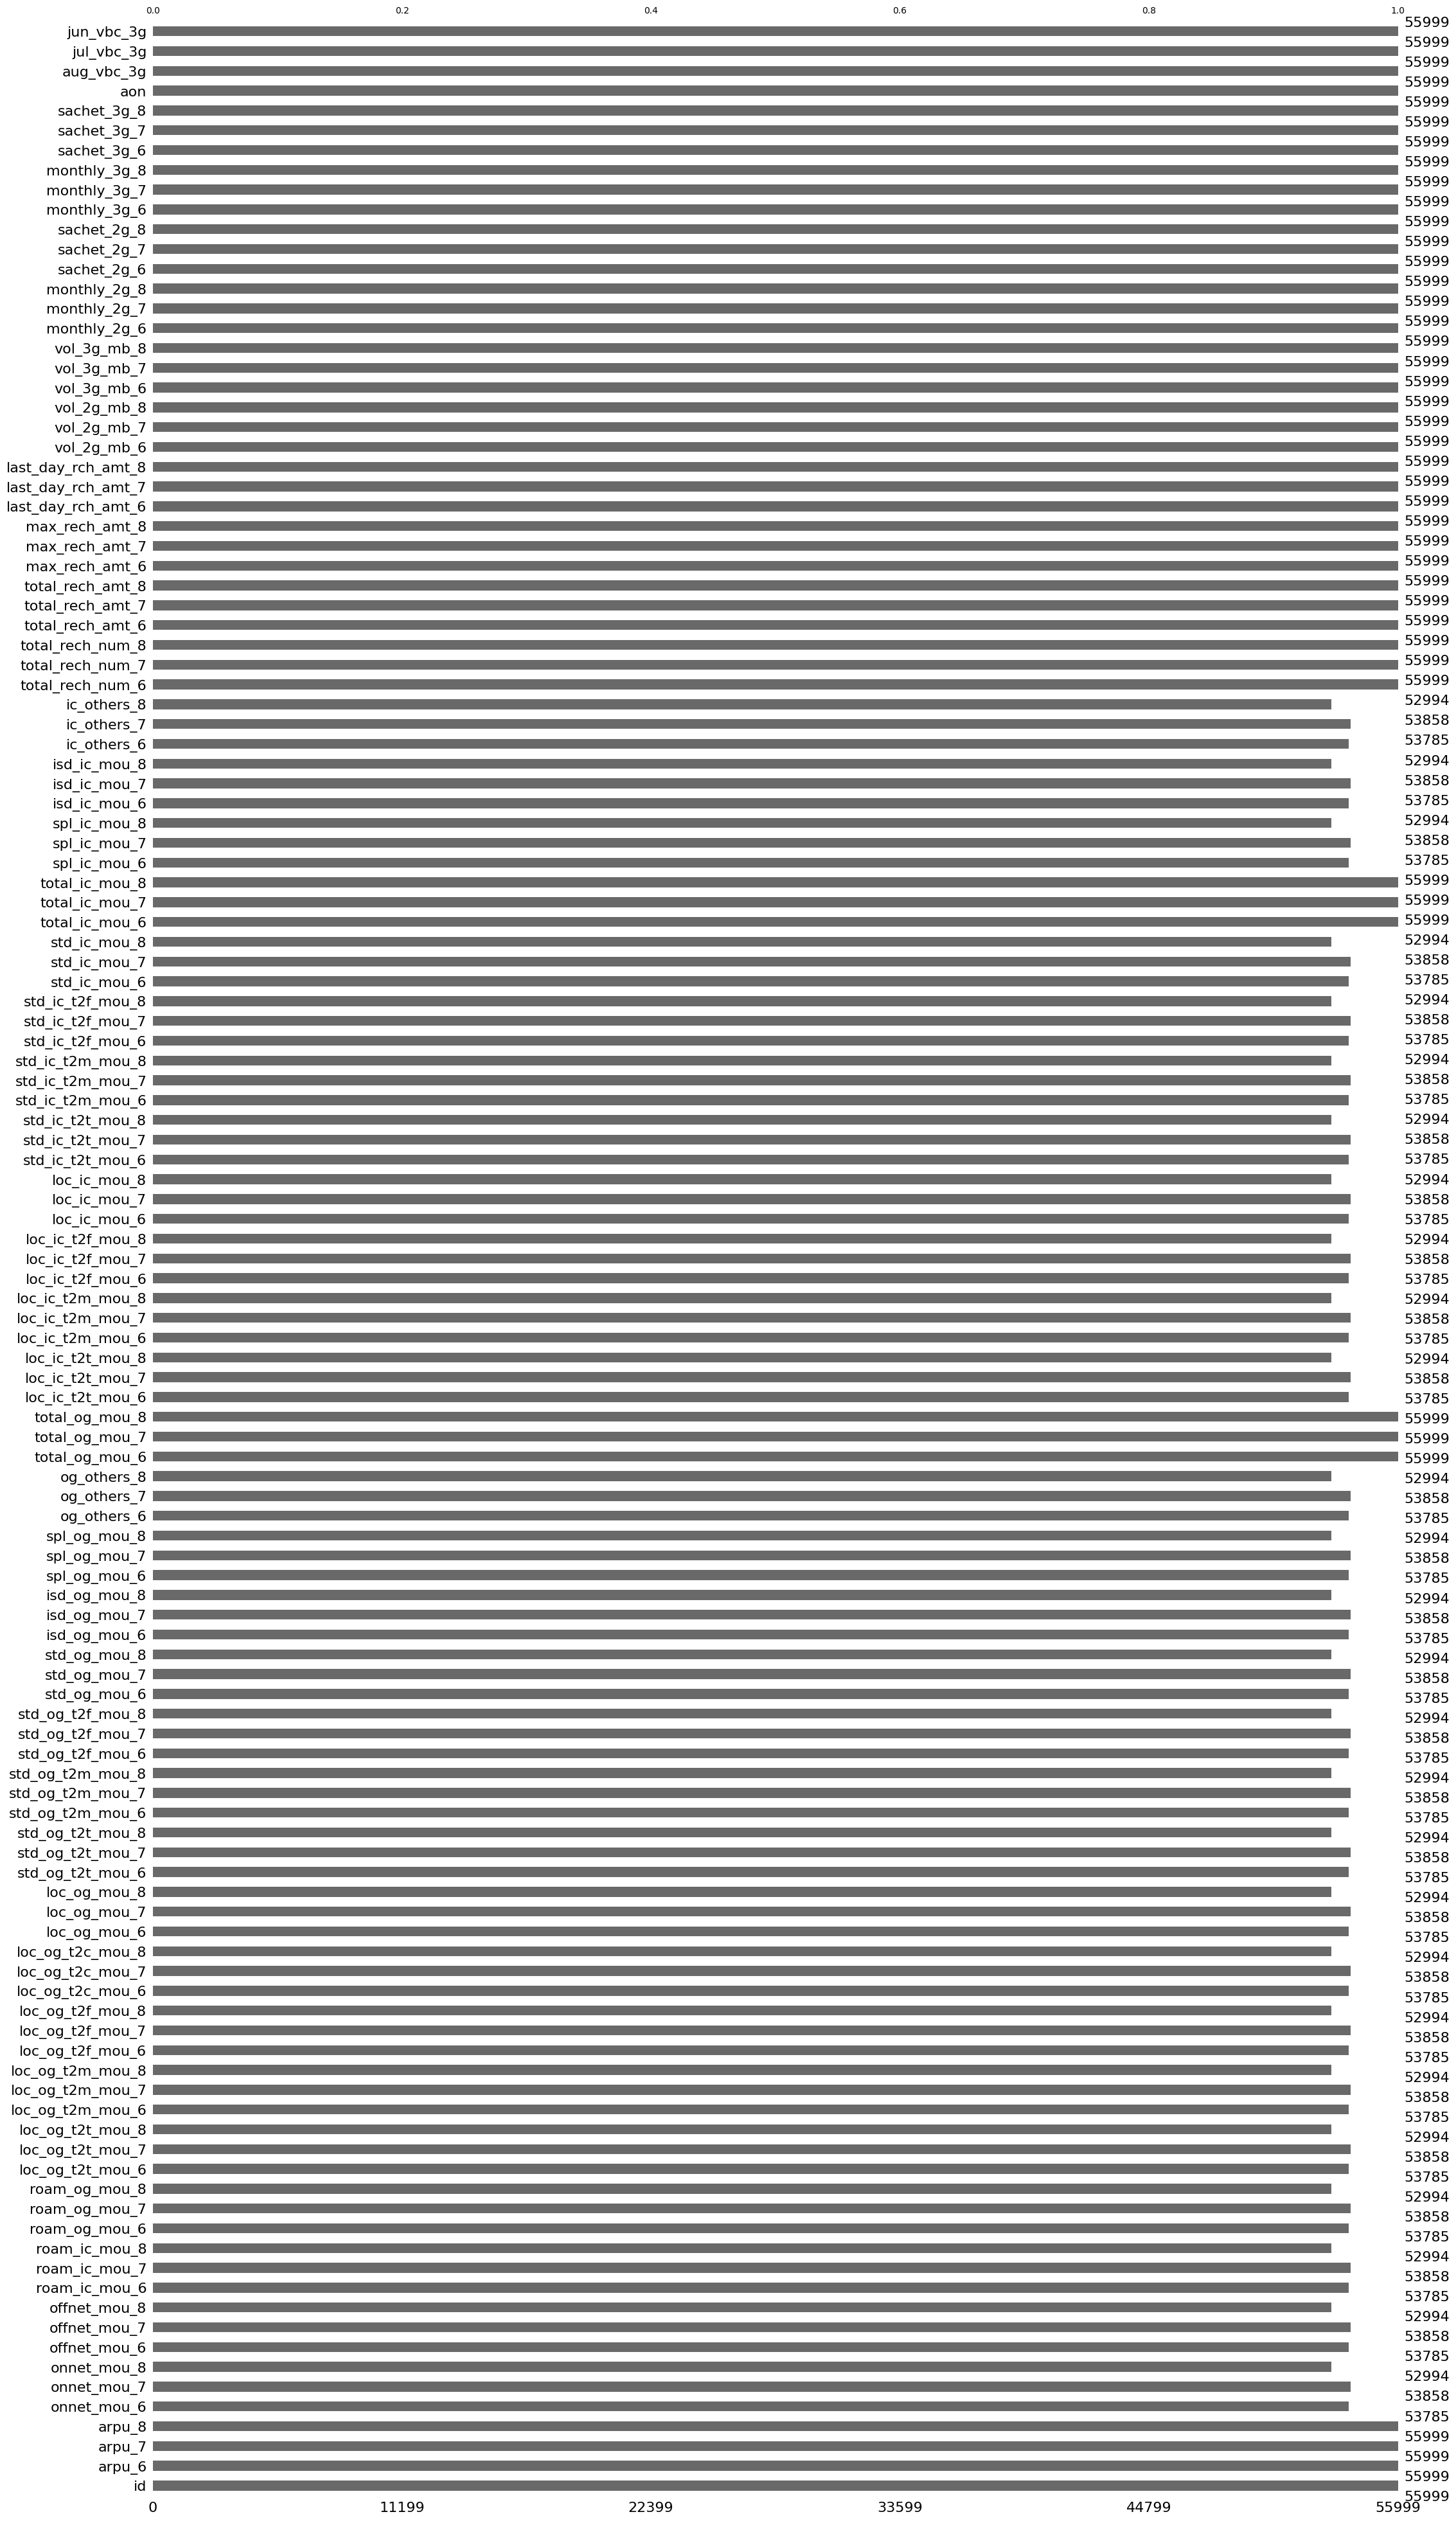

In [24]:
msno.bar(X_train)

In [25]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [26]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

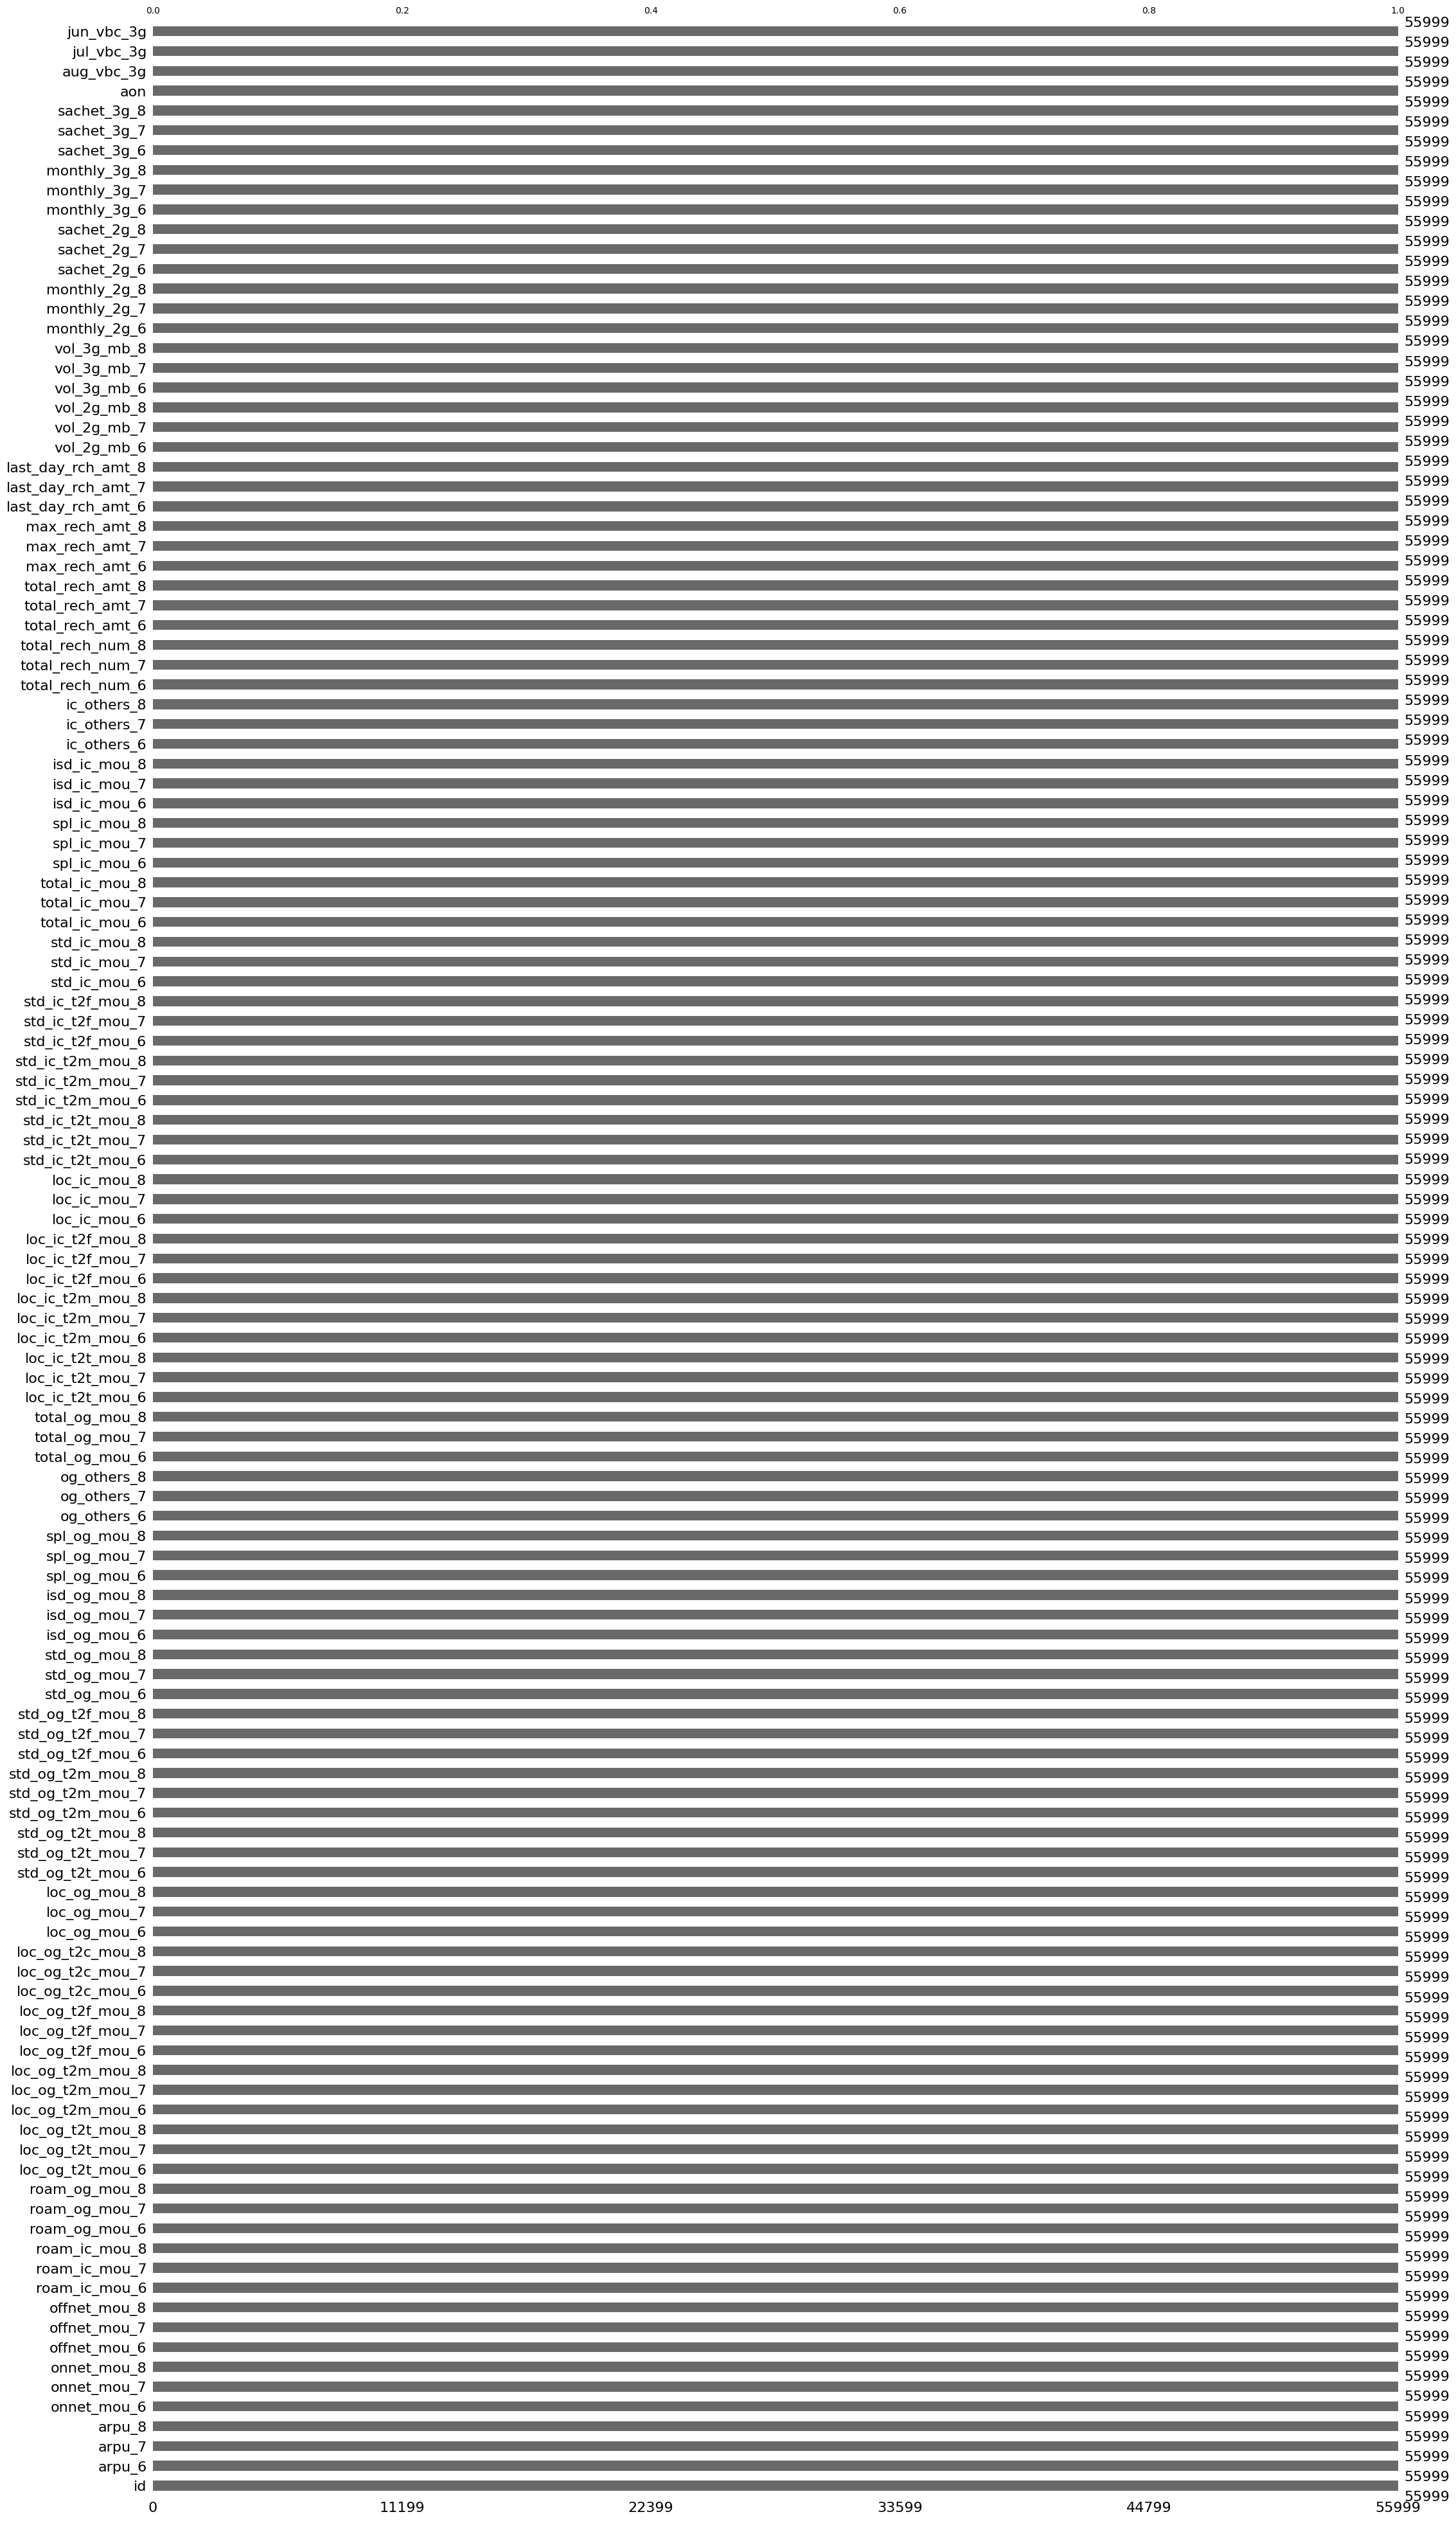

In [27]:
msno.bar(X_train_filtered)

In [28]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 125)
(69999,)


In [29]:
X_train_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean   35019.487312    283.273975    278.703513    279.424418    128.144777   
std    20194.462291    341.829882    352.120000    362.107584    294.687722   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17535.500000     93.425500     86.840500     83.840500      5.480000   
50%    35035.000000    196.987000    191.797000    192.799000     30.990000   
75%    52477.500000    369.641500    365.417000    370.349000    113.485000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     129.503922    126.470127    190.913664    189.681734    186.293352   
std      308.437619    304.776930    311.762845    318.501384    313.872739   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.900000      4.110000     28.930000     26.910000     23.990000   
50%       29.380000     27.930000     89.980000     85.480000     83.290000   
75%      109.485000    106.910000    224.370000    218.840000    217.170000   
max     8157.780000   9977.410000   8362.360000   7043.980000   7460.210000   

       ...  monthly_3g_6  monthly_3g_7  monthly_3g_8   sachet_3g_6  \
count  ...  55999.000000  55999.000000  55999.000000  55999.000000   
mean   ...      0.075680      0.076805      0.081091      0.075983   
std    ...      0.358905      0.377940      0.379780      0.582212   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      9.000000     14.000000     16.000000     29.000000   

        sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean       0.081716      0.086341   1218.615493     67.886515     65.258714   
std        0.640269      0.683772    950.467835    266.250294    266.401674   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        0.000000      0.000000    468.000000      0.000000      0.000000   
50%        0.000000      0.000000    867.000000      0.000000      0.000000   
75%        0.000000      0.000000   1807.000000      0.000000      0.000000   
max       33.000000     38.000000   4337.000000  12916.220000   9165.600000   

         jun_vbc_3g  
count  55999.000000  
mean      60.259914  
std      259.574134  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max    11166.210000  

[8 rows x 125 columns]

## 3.2 Handling Missing data - Test Set

In [30]:
# Display the data types of each column
print(X_test.dtypes)

id               int64
arpu_6         float64
arpu_7         float64
arpu_8         float64
onnet_mou_6    float64
                ...   
sachet_3g_8      int64
aon              int64
aug_vbc_3g     float64
jul_vbc_3g     float64
jun_vbc_3g     float64
Length: 125, dtype: object


In [31]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_test.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [32]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_test_filtered = X_test.apply(pd.to_numeric, errors='coerce')

<Axes: >

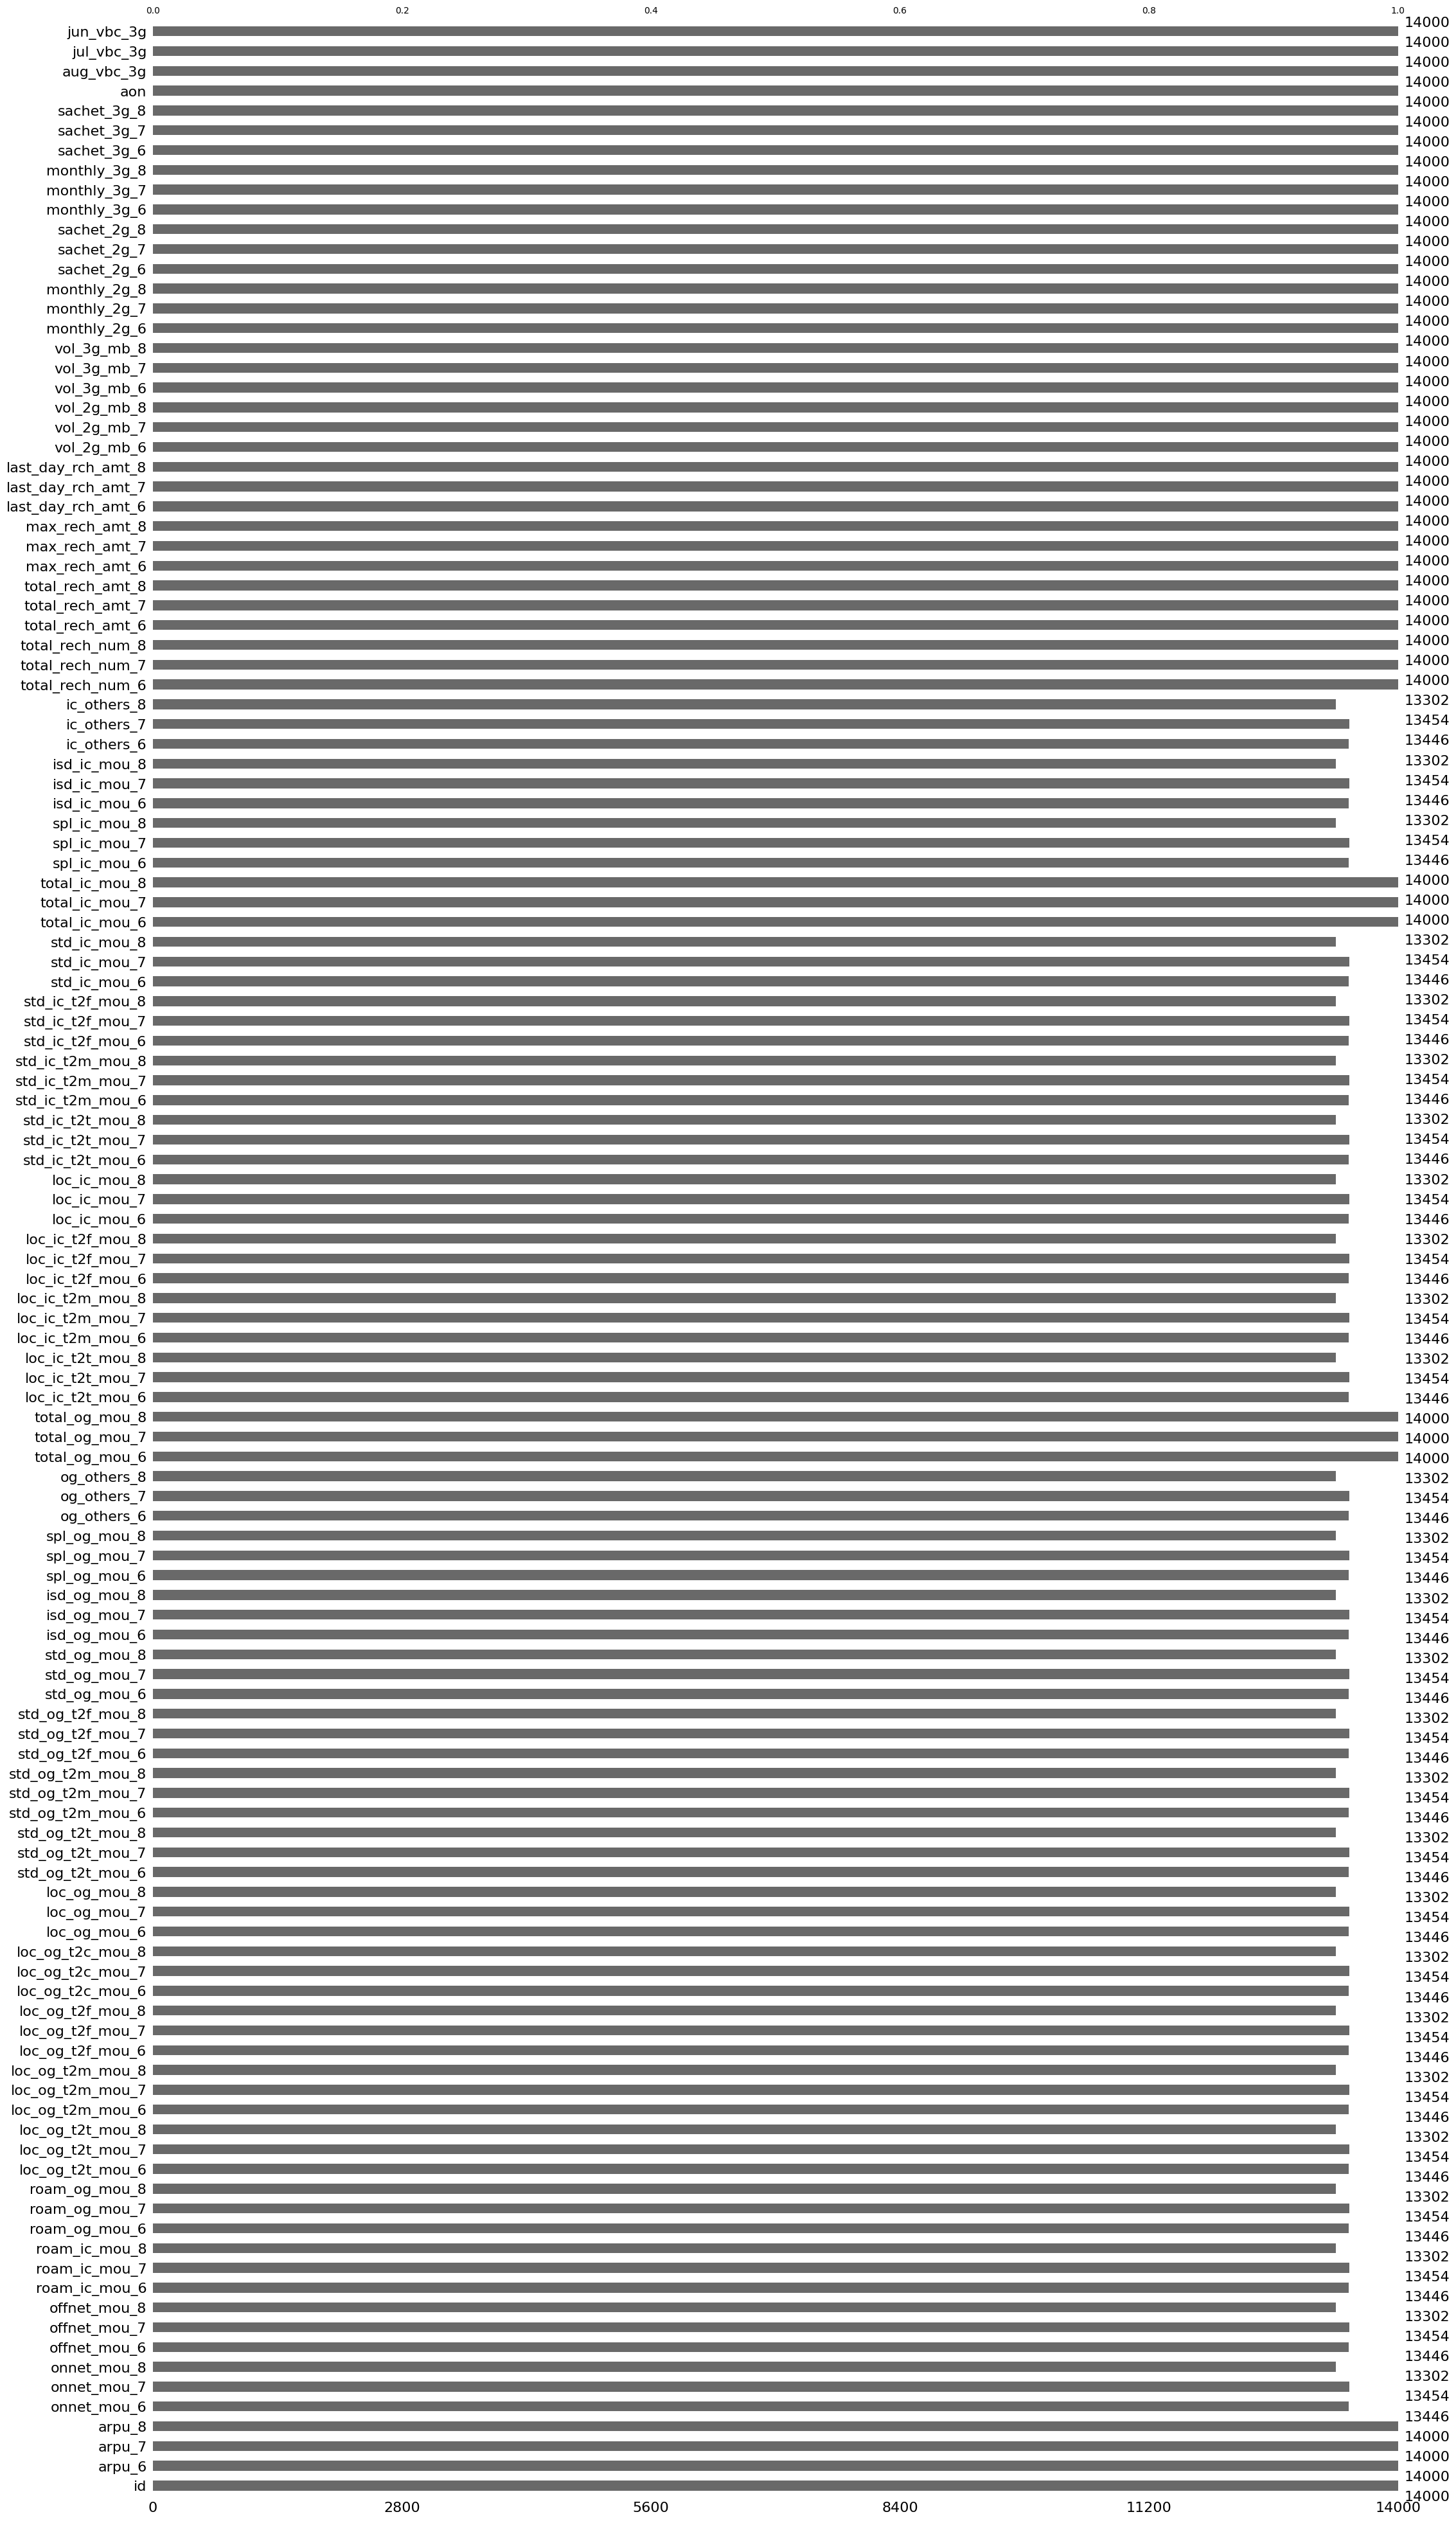

In [33]:
msno.bar(X_test)

In [34]:
missing_data_percent = X_test_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [35]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_test_filtered[impute_cols] = imp.fit_transform(X_test_filtered[impute_cols])

<Axes: >

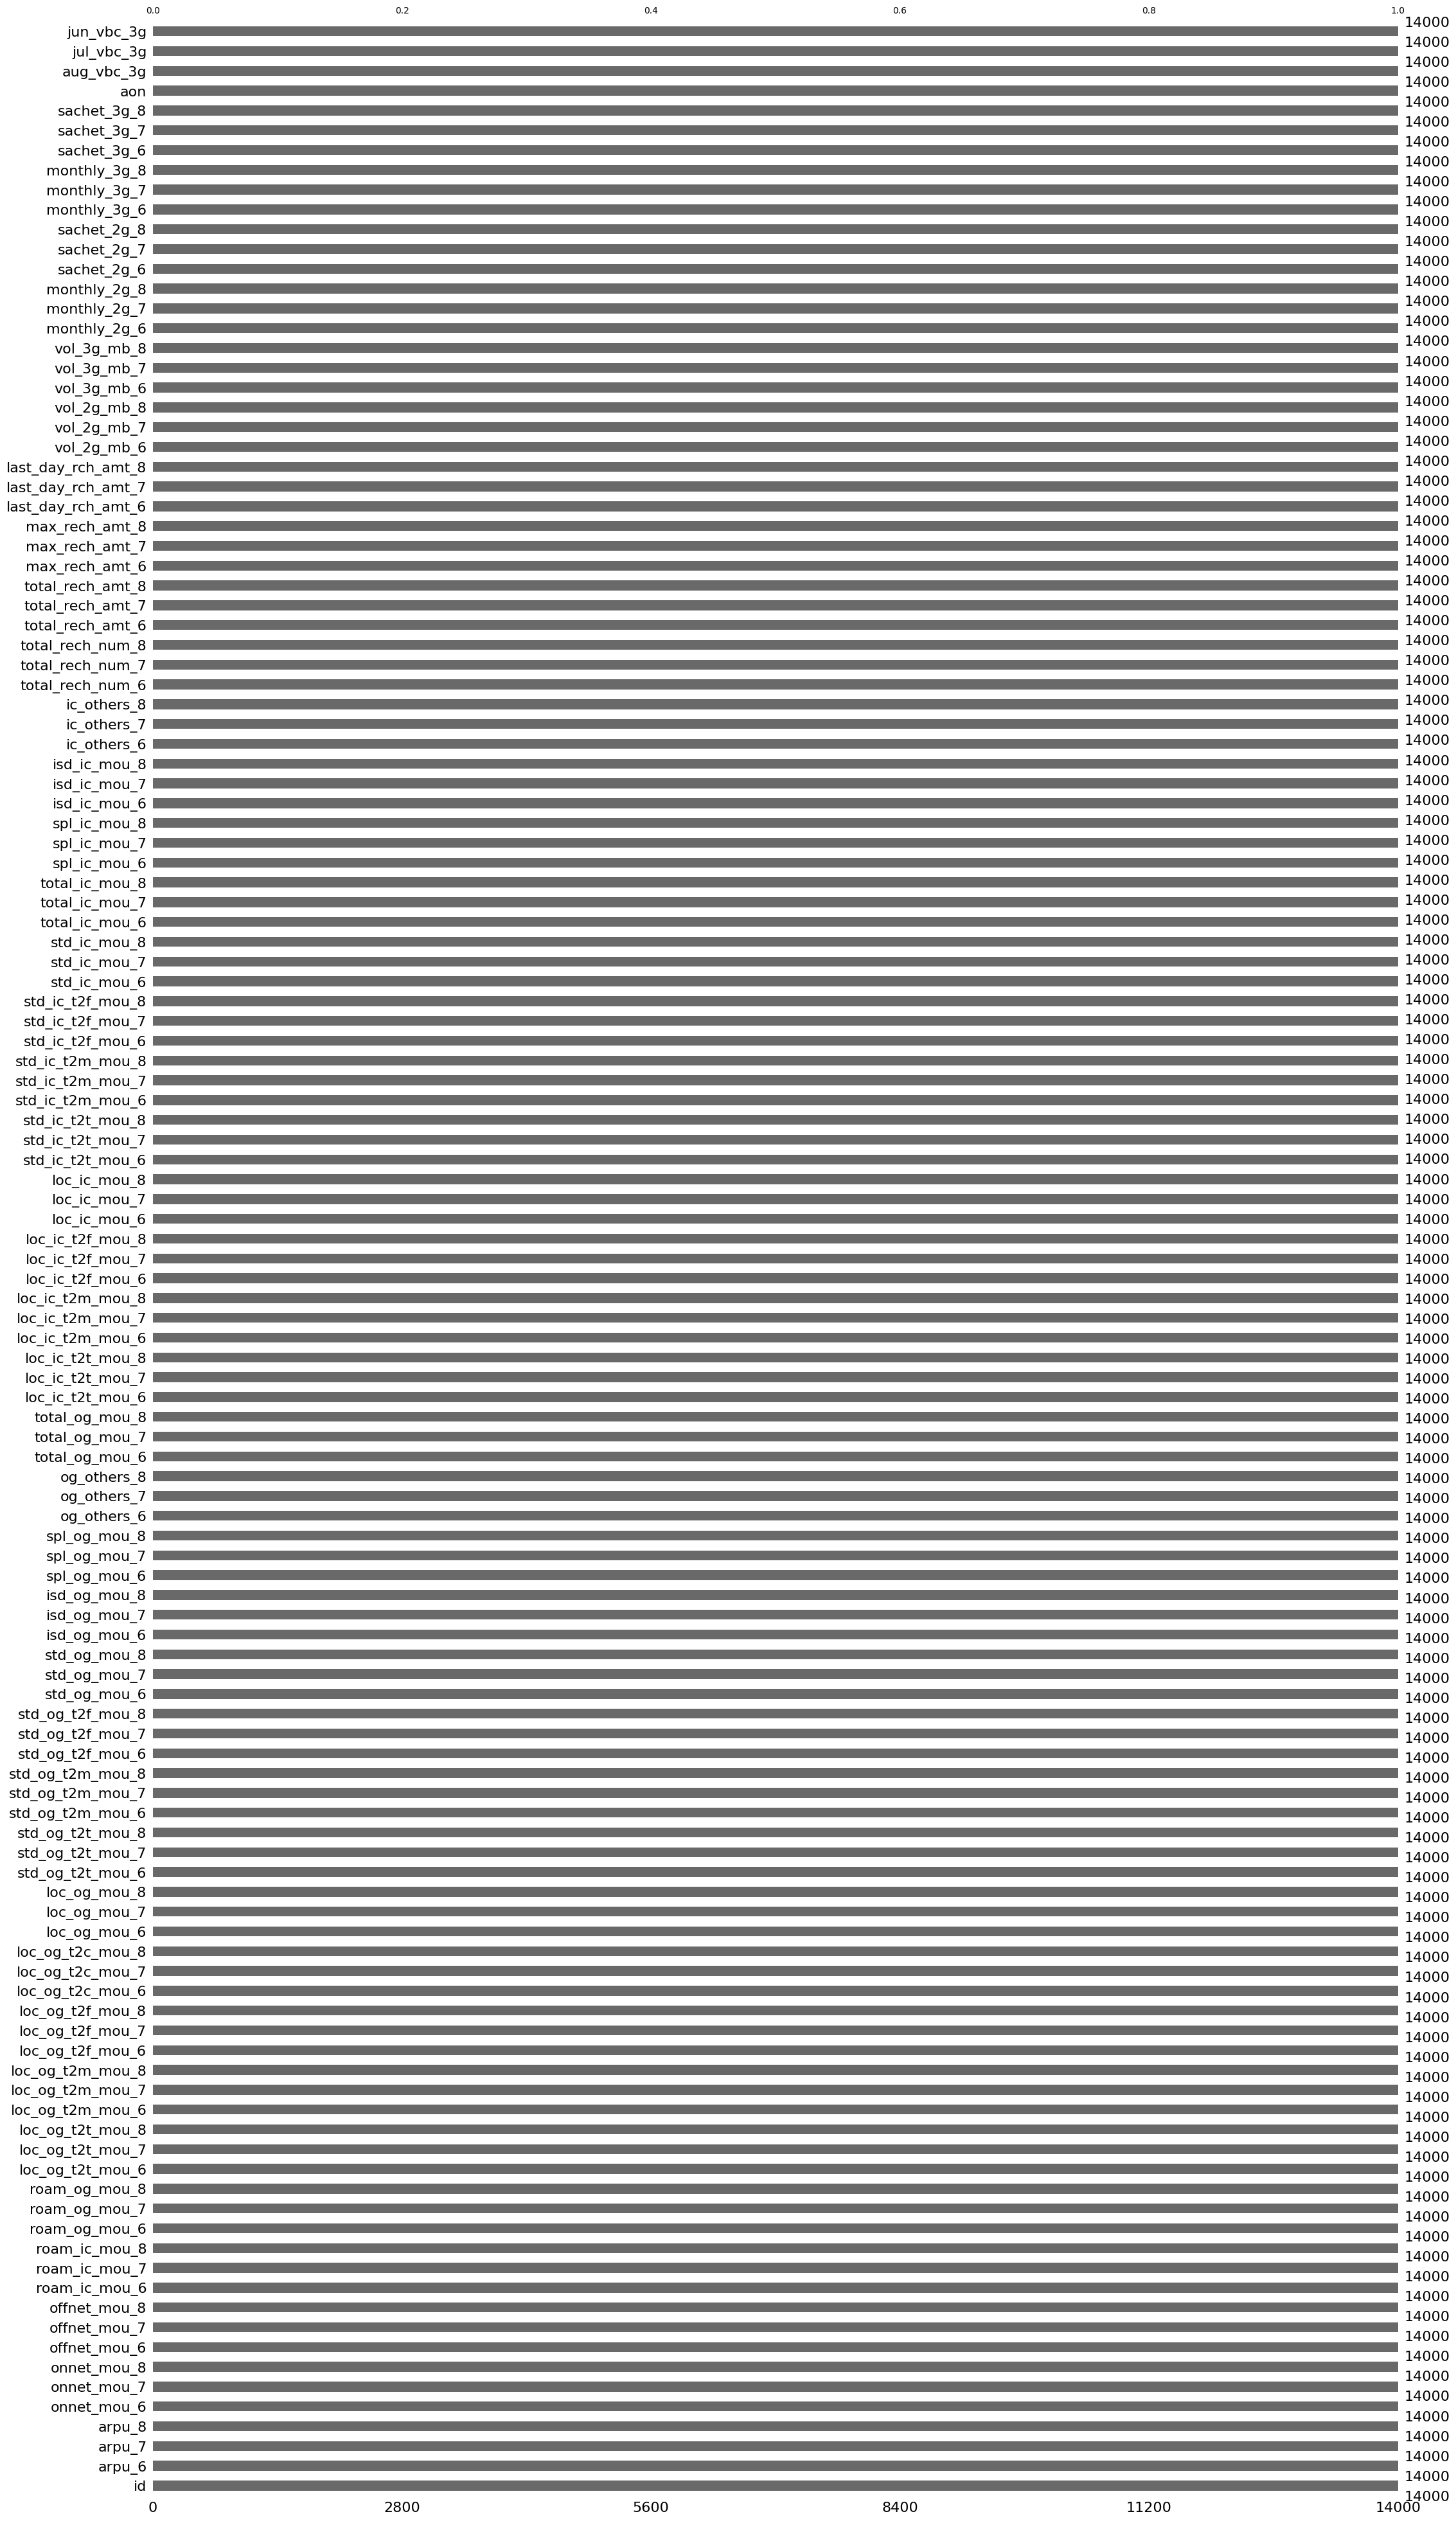

In [36]:
msno.bar(X_test_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

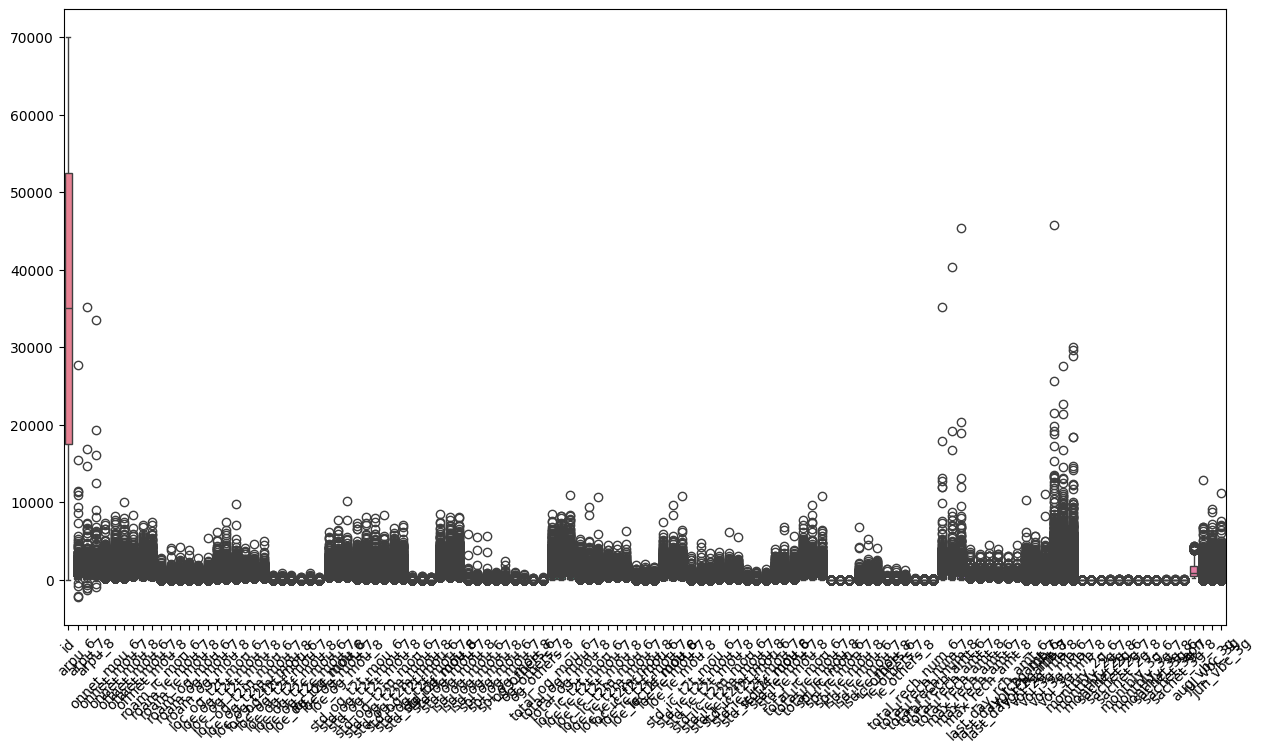

In [37]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [38]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

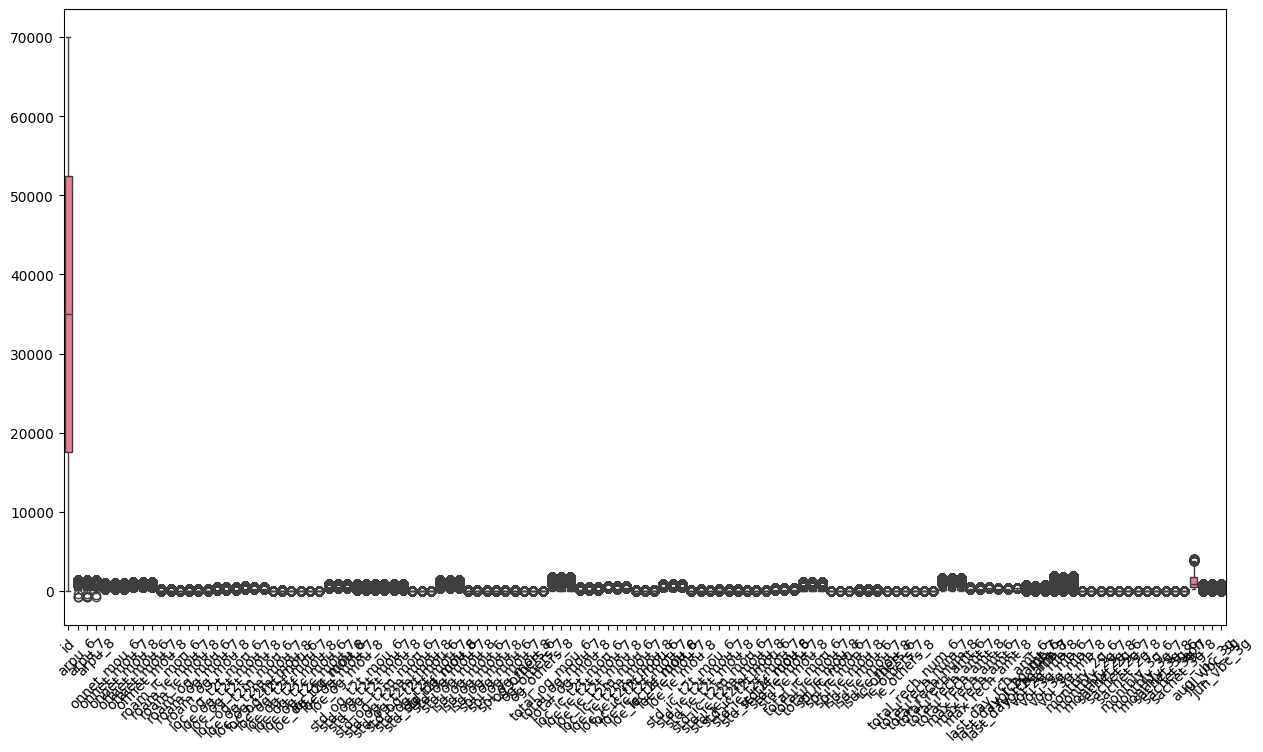

In [39]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [40]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

In [41]:
X_train_filtered1.head()

id    arpu_6   arpu_7       arpu_8  onnet_mou_6  onnet_mou_7  \
15793  15793   437.986    0.000     0.000000        38.78         0.00   
13796  13796   249.659  193.990   173.788000        68.76       142.93   
47608  47608   348.963  192.432     0.000000        78.29        36.79   
9322    9322  1142.776  909.468  1365.747168       783.59       368.64   
13636  13636   256.714  604.018   528.486000        20.04        71.84   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
15793         0.00        823.86          0.00      0.000000  ...   
13796        67.98         74.39         97.01      6.040000  ...   
47608         0.00         91.18         43.24      0.000000  ...   
9322        307.69        609.76        671.91   1127.911569  ...   
13636       141.76        214.98        910.28    550.830000  ...   

       monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
15793           0.0           0.0           0.0          0.0          0.0   
13796           0.0           0.0           0.0          0.0          0.0   
47608           0.0           0.0           0.0          0.0          0.0   
9322            1.0           0.0           0.0          0.0          0.0   
13636           0.0           0.0           0.0          0.0          0.0   

       sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
15793          0.0   185.0         0.0         0.0         0.0  
13796          0.0  1394.0         0.0         0.0         0.0  
47608          0.0  1105.0         0.0         0.0         0.0  
9322           0.0   190.0         0.0         0.0         0.0  
13636          0.0   548.0         0.0         0.0         0.0  

[5 rows x 125 columns]

<Axes: >

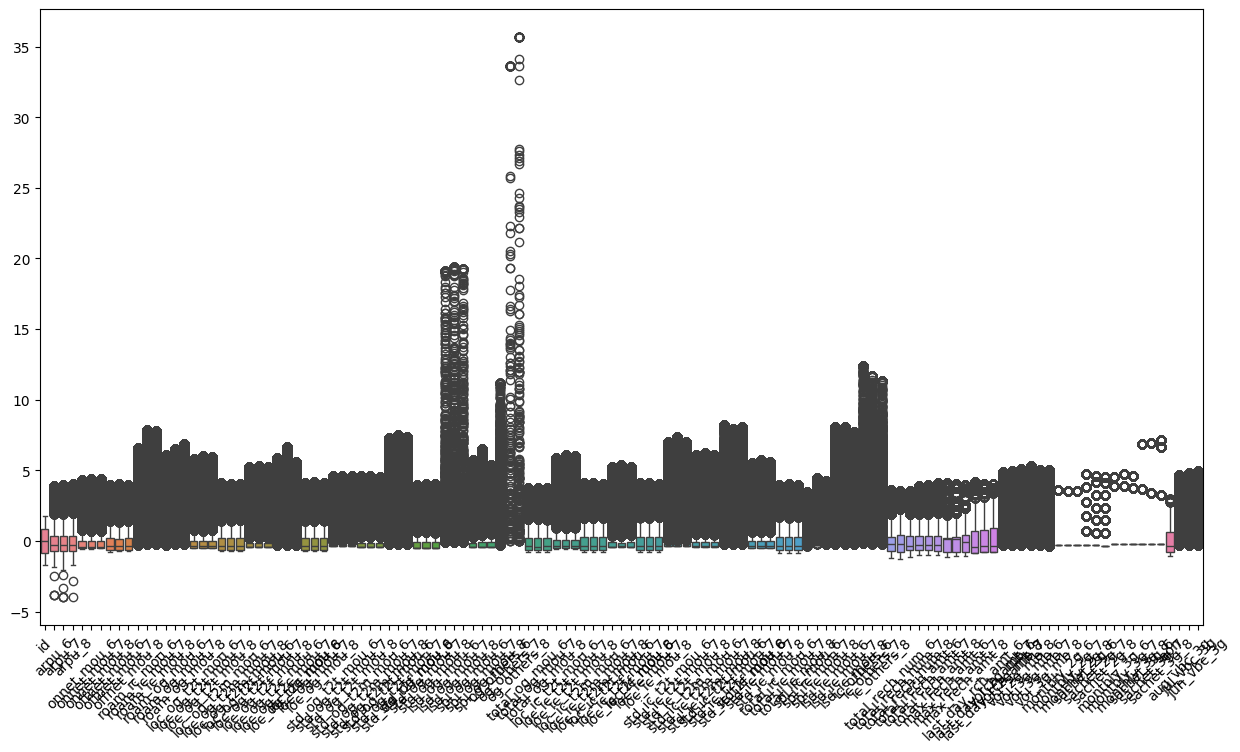

In [42]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

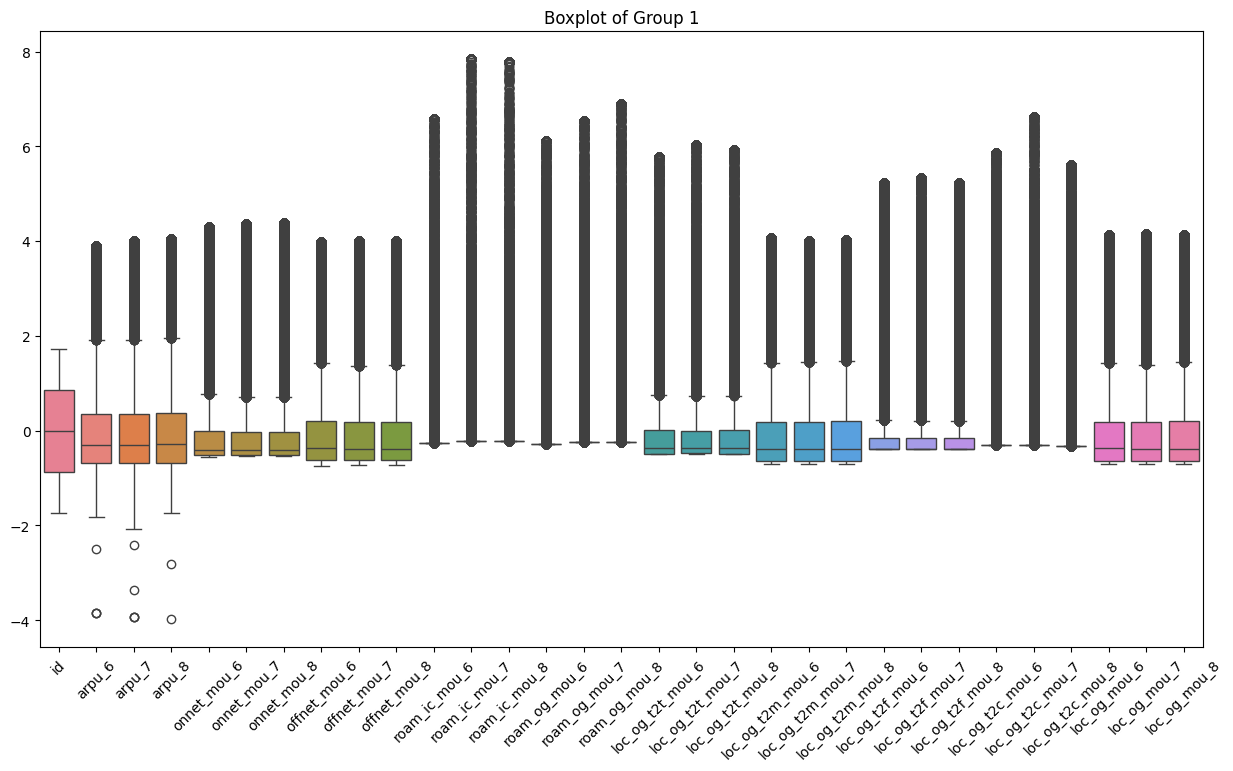

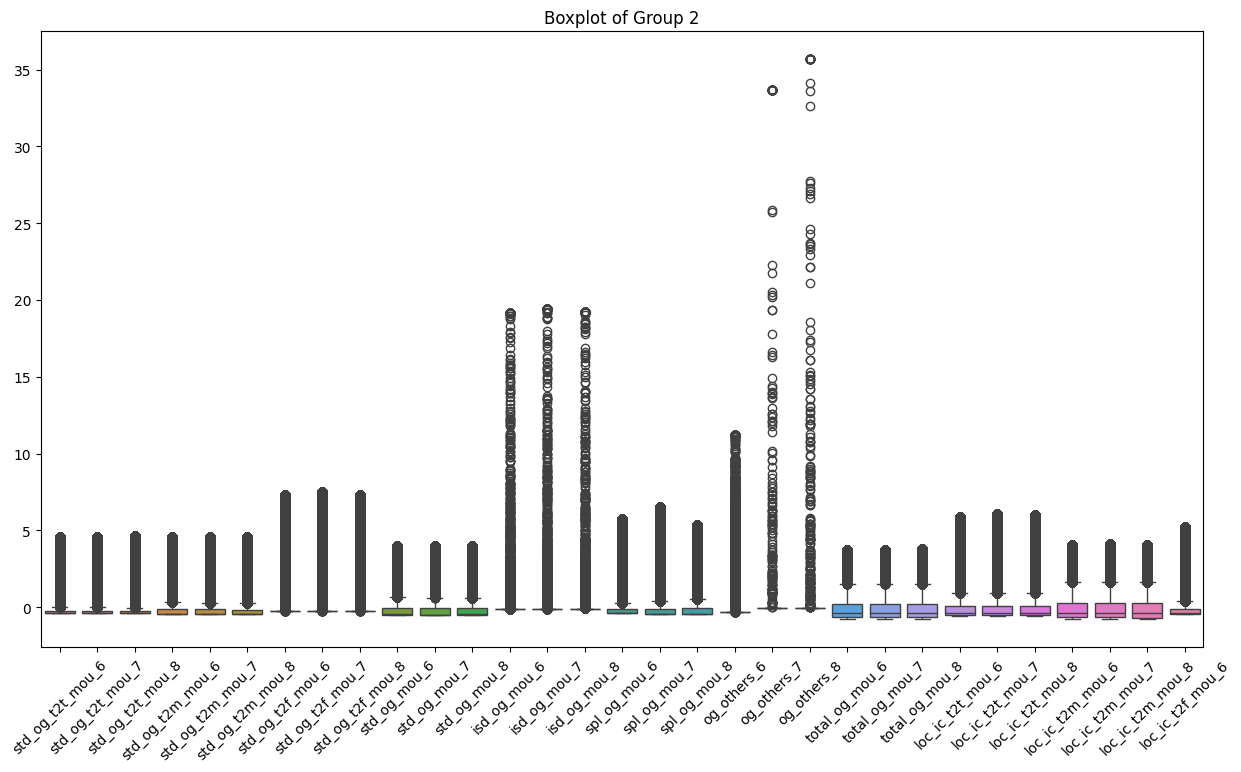

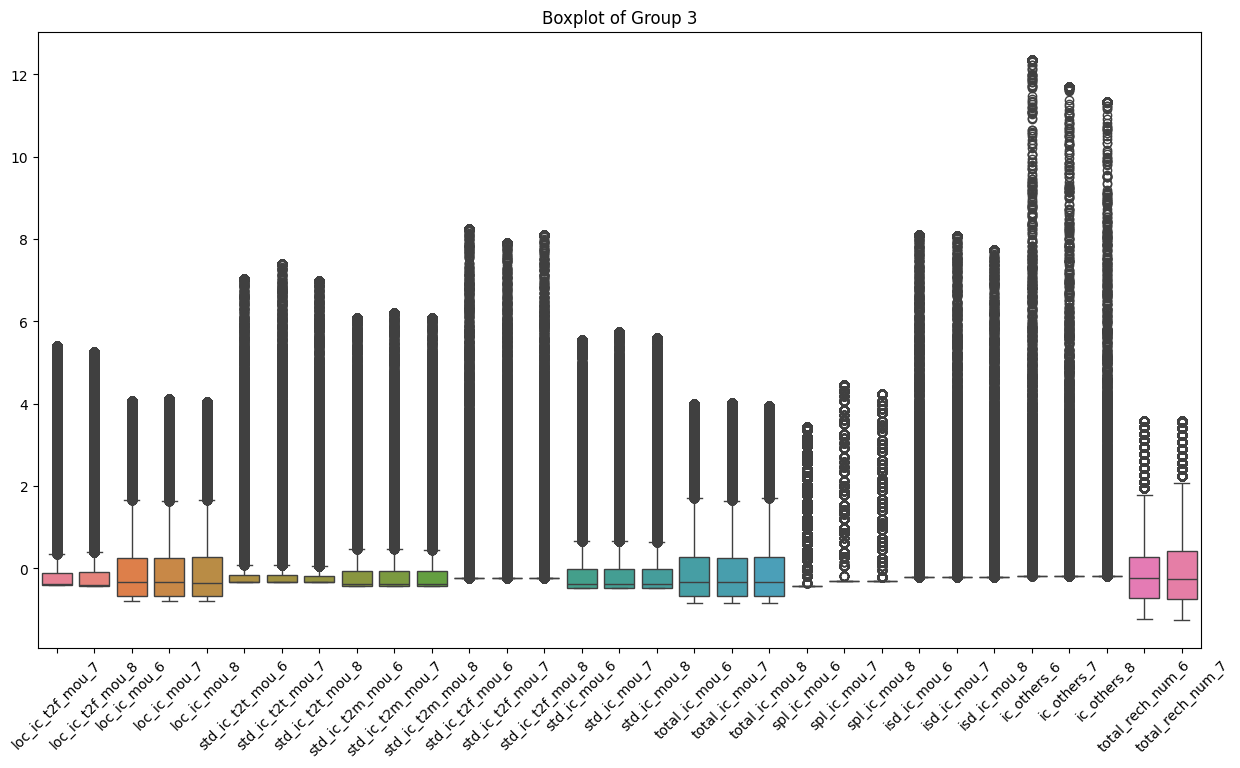

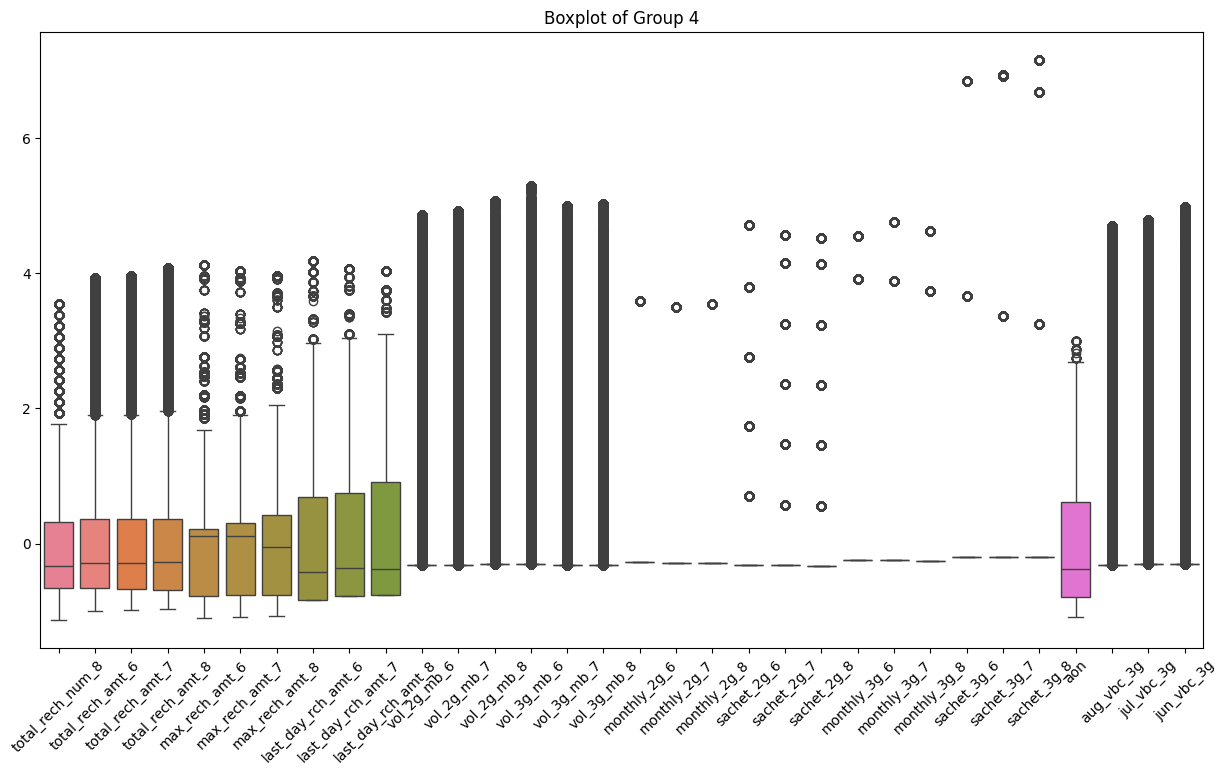

In [43]:
# Convert X_train_filtered2 to a DataFrame with column names from new_vars
X_train_filtered2_df = pd.DataFrame(X_train_filtered2, columns=new_vars)

# Define the number of groups
num_groups = 4
columns_per_group = len(new_vars) // num_groups

# Create separate boxplots for each group of columns
for i in range(num_groups):
    # Select the subset of columns for this group
    start = i * columns_per_group
    end = (i + 1) * columns_per_group if i != num_groups - 1 else len(new_vars)
    group_columns = new_vars[start:end]
    
    # Create the boxplot for the current group by selecting only the relevant columns
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=45)
    sns.boxplot(data=X_train_filtered2_df[group_columns])
    plt.title(f"Boxplot of Group {i + 1}")
    plt.show()

<Axes: >

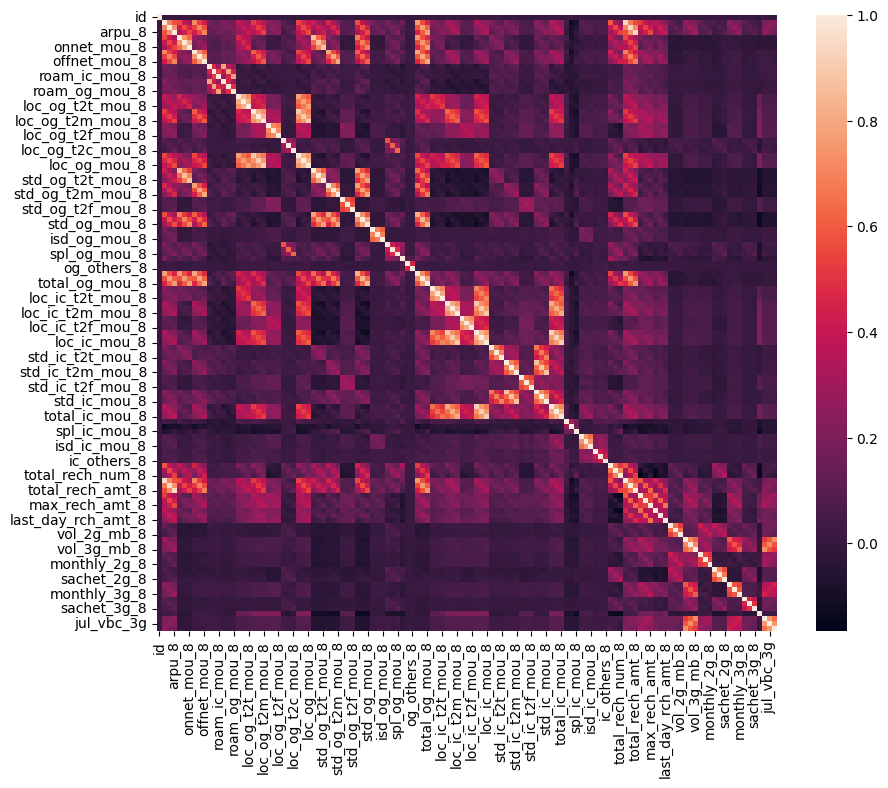

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

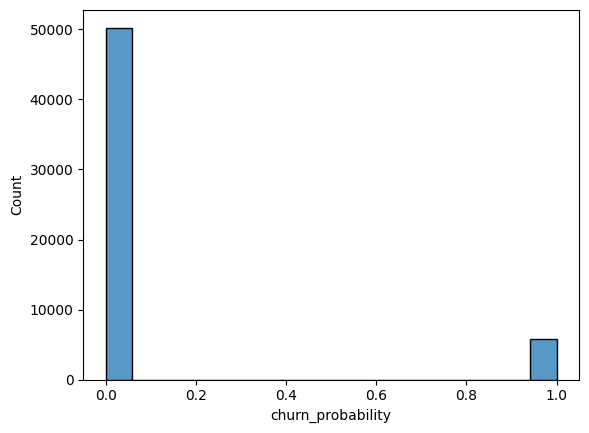

In [45]:
#Distribution for the churn probability
sns.histplot(y_train)

### Selecting Features with RFE

In [46]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 125)
(69999,)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=13)  # specify n_features_to_select as a keyword argument
rfe = rfe.fit(X_train_filtered2, y_train)
print(rfe.support_)  # Print the boolean results


[False  True False False False False False False False False False False
 False False False False False False  True False False  True False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
  True False False  True False False  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False  True False False
  True False False  True False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [54]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('id', False, 108),
 ('arpu_6', True, 1),
 ('arpu_7', False, 10),
 ('arpu_8', False, 49),
 ('onnet_mou_6', False, 25),
 ('onnet_mou_7', False, 106),
 ('onnet_mou_8', False, 7),
 ('offnet_mou_6', False, 35),
 ('offnet_mou_7', False, 99),
 ('offnet_mou_8', False, 6),
 ('roam_ic_mou_6', False, 78),
 ('roam_ic_mou_7', False, 68),
 ('roam_ic_mou_8', False, 92),
 ('roam_og_mou_6', False, 37),
 ('roam_og_mou_7', False, 85),
 ('roam_og_mou_8', False, 8),
 ('loc_og_t2t_mou_6', False, 23),
 ('loc_og_t2t_mou_7', False, 42),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 21),
 ('loc_og_t2m_mou_7', False, 101),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 51),
 ('loc_og_t2f_mou_7', False, 104),
 ('loc_og_t2f_mou_8', False, 103),
 ('loc_og_t2c_mou_6', False, 72),
 ('loc_og_t2c_mou_7', False, 64),
 ('loc_og_t2c_mou_8', False, 70),
 ('loc_og_mou_6', False, 22),
 ('loc_og_mou_7', False, 41),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 36),
 ('std_og_t2t_mou_7

In [55]:
col = X_train.columns[rfe.support_]

In [61]:
# Variables selected by RFE 
print(col)

Index(['arpu_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'total_rech_amt_8',
       'max_rech_amt_8', 'last_day_rch_amt_8'],
      dtype='object')


##### Assessing the model with StatsModels

In [59]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train_filtered2, y_train)

LogisticRegression(C=1000000000.0)

In [63]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
import statsmodels.api as sm
logm4 = sm.GLM(y_train,(sm.add_constant(X_train_filtered2)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55873
Model Family:                Binomial   Df Model:                          125
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11792.
Date:                Sat, 16 Nov 2024   Deviance:                       23585.
Time:                        12:35:32   Pearson chi2:                 1.56e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2134
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2169      0.049    -86.584      0.000      -4.312      -4.121
x1             0.0041      0.017      0.247      0.805      -0.029       0.037
x2             0.4578      0.068      6.701      0.000       0.324       0.592
x3             0.3281      0.074      4.446      0.000       0.183       0.473
x4             0.1083      0.083      1.310      0.190      -0.054       0.270
x5            -0.1508      0.110     -1.368      0.171      -0.367       0.065
x6            -0.0128      0.135     -0.095      0.925      -0.277       0.252
x7            -0.3604      0.154     -2.343      0.019      -0.662      -0.059
x8            -0.0767      0.110     -0.698      0.485      -0.292       0.139
x9            -0.0221      0.133     -0.166      0.868      -0.283       0.239
x10           -0.5465      0.149     -3.677      0.000      -0.838      -0.255
x11            0.0190      0.027      0.695      0.487      -0.035       0.072
x12            0.0465      0.027      1.743      0.081      -0.006       0.099
x13            0.0118      0.024      0.499      0.618      -0.035       0.058
x14            0.0612      0.030      2.044      0.041       0.003       0.120
x15           -0.0127      0.028     -0.458      0.647      -0.067       0.042
x16            0.2352      0.027      8.569      0.000       0.181       0.289
x17           -0.2148      0.101     -2.127      0.033      -0.413      -0.017
x18            0.2155      0.129      1.669      0.095      -0.038       0.469
x19           -0.5517      0.173     -3.182      0.001      -0.892      -0.212
x20           -0.3494      0.143     -2.444      0.015      -0.629      -0.069
x21            0.2615      0.182      1.440      0.150      -0.094       0.617
x22           -0.9271      0.239     -3.878      0.000      -1.396      -0.459
x23           -0.0623      0.034     -1.814      0.070      -0.130       0.005
x24            0.0226      0.042      0.541      0.588      -0.059       0.104
x25           -0.0338      0.047     -0.712      0.476      -0.127       0.059
x26           -0.0235      0.022     -1.071      0.284      -0.066       0.019
x27            0.0373      0.024      1.543      0.123      -0.010       0.085
x28            0.0421      0.032      1.321      0.187      -0.020       0.105
x29            0.5952      0.225      2.651      0.008       0.155       1.035
x30           -0.4703      0.279     -1.684      0.092      -1.018       0.077
x31            1.1552      0.367      3.148      0.002       0.436       1.874
x32            0.1735      0.101      1.715      0.086      -0.025       0.372
x33            0.1081      0.128      0.845      0.398      -0.143       0.359
x34           -0.1545      0.162     -0.956      0.339      -0.471       0.162
x35            0.0815      0.091      0.896      0.370      -0.097       0.260
x3

### we need to drop variables with high p-value and cross-correlation

In [64]:
X_test[col].shape
#res = modres.predict(X_test[col])

(14000, 13)

### Making Predictions with RFE

In [66]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test_filtered)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

1
0  2.142339e-37
1  7.562989e-45
2  5.044527e-90
3  1.000000e+00
4  1.986108e-43

In [67]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn_probability
55321                  0
8447                   0
57473                  0
64047                  0
3005                   0

In [80]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns using reindex
y_pred_final = y_pred_final.reindex(columns=['CustID', 'churn_probability', 'Churn_Prob'])

# Let's see the head of y_pred_final
y_pred_final.head()


CustID  churn_probability    Churn_Prob
0       0                  0  2.142339e-37
1       1                  0  7.562989e-45
2       2                  0  5.044527e-90
3       3                  0  1.000000e+00
4       4                  0  1.986108e-43

In [81]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

CustID  churn_probability    Churn_Prob  predicted
0       0                  0  2.142339e-37          0
1       1                  0  7.562989e-45          0
2       2                  0  5.044527e-90          0
3       3                  0  1.000000e+00          1
4       4                  0  1.986108e-43          0

### RFE Model Evaluation

In [82]:
from sklearn import metrics

In [83]:
print(y_pred_final.isnull().sum())


CustID               0
churn_probability    0
Churn_Prob           0
predicted            0
dtype: int64


In [84]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn_probability , y_pred_final.predicted )
confusion

array([[8299, 4311],
       [ 595,  795]])

In [86]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.predicted)

0.6495714285714286

In [48]:


# converting to data frame, in order to extract columns
X_train_filtered2_df = pd.DataFrame(X_train_filtered2)


#### Supriyo - could you start PCA here

In [42]:
#Segregating the train data for high value customers
## This needs to be done before Scaling ....
X_train_filtered.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [43]:
X_train_filtered.shape

(55999, 125)

In [44]:
X_train_filtered.shape

(55999, 125)

In [45]:
y_train.value_counts()

0    50302
1     5697
Name: churn_probability, dtype: int64

In [46]:
y_test.value_counts()

0    12565
1     1435
Name: churn_probability, dtype: int64

<Axes: xlabel='churn_probability', ylabel='Count'>

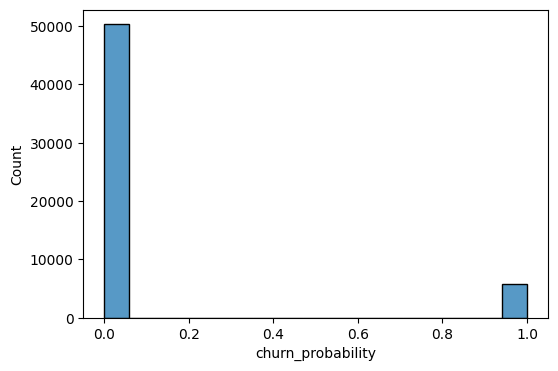

In [47]:
#Distribution for the churn probability
plt.figure(figsize=(6, 4))
sns.histplot(y_train)

In [50]:
from imblearn.over_sampling import SMOTE

In [52]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)


(100604, 125)
(100604,)
